In [ ]:
# | default_exp framelabels
# | export
import torch
from transformers import pipeline
from functools import partial
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


class FramingLabels:
    def __init__(self, base_model, candidate_labels, batch_size=16):
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.base_pipeline = pipeline("zero-shot-classification", model=base_model, device=device)
        self.candidate_labels = candidate_labels
        self.classifier = partial(
            self.base_pipeline, candidate_labels=candidate_labels, multi_label=True, batch_size=batch_size
        )

    def order_scores(self, dic):
        indices_order = [dic["labels"].index(l) for l in self.candidate_labels]
        scores_ordered = np.array(dic["scores"])[indices_order].tolist()
        return scores_ordered

    def get_ordered_scores(self, sequence_to_classify):
        if type(sequence_to_classify) == list:
            res = []
            for out in tqdm.tqdm(self.classifier(sequence_to_classify)):
                res.append(out)
        else:
            res = self.classifier(sequence_to_classify)
        if type(res) == list:
            scores_ordered = list(map(self.order_scores, res))
            scores_ordered = list(map(list, zip(*scores_ordered)))  # reorder
        else:
            scores_ordered = self.order_scores(res)
        return scores_ordered

    def get_label_names(self):
        label_names = [l.split(":")[0].split(" ")[0] for l in self.candidate_labels]
        return label_names

    def __call__(self, sequence_to_classify):
        scores = self.get_ordered_scores(sequence_to_classify)
        label_names = self.get_label_names()
        return dict(zip(label_names, scores))

    def visualize(self, name_to_score_dict, threshold=0.5, **kwargs):
        fig, ax = plt.subplots()

        cp = sns.color_palette()

        scores_ordered = list(name_to_score_dict.values())
        label_names = list(name_to_score_dict.keys())

        colors = [cp[0] if s > 0.5 else cp[1] for s in scores_ordered]
        ax.barh(label_names[::-1], scores_ordered[::-1], color=colors[::-1], **kwargs)
        plt.xlim(left=0)
        plt.tight_layout()
        return fig, ax

d:\miniconda\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 7/7 [00:00<?, ?it/s]
C:\Users\Nico\AppData\Local\Temp\ipykernel_36164\1247514556.py:60: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left=0)


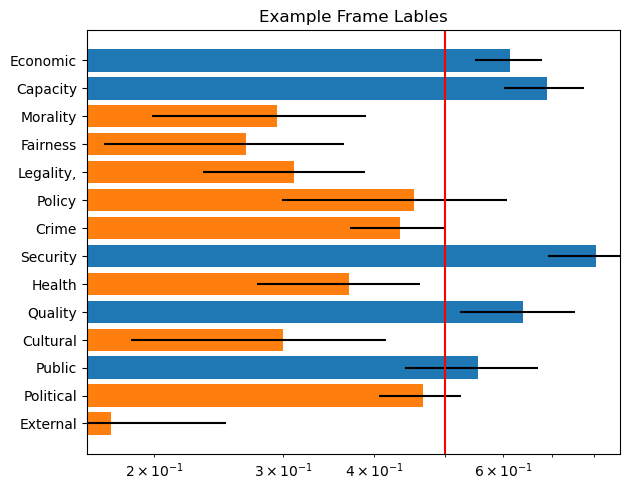

In [ ]:
base_model = "facebook/bart-large-mnli"
candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
]

example_list = [
    "In 2010, CFCs were banned internationally due to their harmful effect on the ozone layer.",
    "In 2021, doctors prevented the spread of the virus by vaccinating with Pfizer.",
    "We must fight for our freedom.",
    "The government prevents our freedom.",
    "They prevent the spread.",
    "We fight the virus.",
    "I believe that we should act now.\nThere is no time to waste.",
]

framing_label_model = FramingLabels(base_model, candidate_labels)
assert type(framing_label_model(example_list[0])) == dict
assert type(framing_label_model(example_list)) == dict
test_labels = framing_label_model(example_list)

test_labels_df = pd.DataFrame(test_labels)
import matplotlib.ticker as mticker

_, ax = framing_label_model.visualize(test_labels_df.mean().to_dict(), xerr=test_labels_df.sem(), log="True")
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.xticks([0.1, 0.5, 1])
plt.title("Example Frame Lables")
plt.axvline(0.5, color="red")

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()